In [1]:
from os.path import join
from datetime import datetime

import numpy as np
import pandas as pd
from pymagicc.io import MAGICCData

from openscm.core import Core, ParameterSet
from openscm.utils import convert_datetime_to_openscm_time
from openscm.units import unit_registry
from openscm.internal import Adapter
from openscm.adapters import get_adapter, MAGICC6
from openscm.highlevel import OpenSCMDataFrame

<IPython.core.display.Javascript object>

In [2]:
import matplotlib
%matplotlib inline

In [3]:
DATA_PATH = join("..", "data", "rcps")

In [4]:
def load_rcp_data(filepath, **kwargs):
    rcp = MAGICCData(
        filepath,
        **kwargs
    )
    
    return OpenSCMDataFrame(rcp.data.copy())

rcp26 = load_rcp_data(
    join(DATA_PATH, "RCP26_EMISSIONS.DAT"), 
    model="IMAGE",
    scenario="RCP26",
)
rcp26.head()

,variable,todo,unit,region,climate_model,model,scenario,time,value
5888,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1765-07-12 00:00:00,0.000000
5889,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1766-07-12 00:00:00,0.106998
5890,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1767-07-12 00:00:00,0.133383
5891,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1768-07-12 00:00:00,0.159847
5892,Emissions|BC,SET,Mt BC / yr,World,unspecified,IMAGE,RCP26,1769-07-12 00:00:00,0.186393


In [5]:
rcps = OpenSCMDataFrame(rcp26.data.copy())
rcp_dict = {
    "MiniCAM": "RCP45",
    "AIM": "RCP60",
    "MESSAGE": "RCP85",
}
for model, scenario in rcp_dict.items():
    rcpdata = load_rcp_data(
        join(DATA_PATH, "{}_EMISSIONS.DAT".format(scenario)),
        model=model,
        scenario=scenario,
    )
    rcps.append(rcpdata, inplace=True)

In [6]:
rcps.scenarios()

0    RCP26
1    RCP45
2    RCP60
3    RCP85
Name: scenario, dtype: object

In [7]:
# TODO: put something like this in gap between high and low level interfaces
def convert_openscm_df_to_parameter_set(openscm_df):
    # make internal
    ONE_YEAR_INT = int(1*unit_registry("yr").to("s").magnitude)
    
    parameter_set = ParameterSet()
    for (variable, region), df in openscm_df.data.groupby(["variable", "region"]):
        df = df.sort_values("time")
        variable_openscm = tuple(variable.split("|"))  # TODO: remove hard coding
        region_openscm = tuple(region.split("|"))
        # TODO: discuss why this is and make handling better
        assert region_openscm[0] == "World"
        region_openscm = region_openscm[1:] if len(region_openscm) > 1 else ()
        unit = df.unit.unique()
        assert len(unit) == 1, "emissions timeseries should all be in one unit"  # TODO: remove this restriction
        unit = unit[0]
        syr = df.time.min().year
        assert syr == 1765, "have not considered cases other than the RCPs yet"  # TODO: remove this restriction
        eyr = df.time.max().year
        assert eyr == 2500, "have not considered cases other than the RCPs yet"  # TODO: remove this restriction
        assert len(df) == 736, "have not considered cases other than the RCPs read in by pymagicc yet"  # TODO: remove this restriction
        tstep = ONE_YEAR_INT  # having passed all above, can safely assume this [TODO: remove this assumption]

        emms_view = parameter_set.get_writable_timeseries_view(
            variable_openscm,
            region_openscm,
            unit,
            convert_datetime_to_openscm_time(datetime(syr, 1, 1, 0, 0, 0)),
            tstep
        )
        emms_view.set_series(df["value"].values)

    return parameter_set

In [8]:
from datetime import datetime, timedelta
import numpy as np

def convert_parameter_set_to_openscmdf(
    parameter_set, 
    climate_model,
    scenario,
    model="unspecified",  
):
    for key, value in parameter_set._world._parameters.items():
        values = value._data
        if isinstance(values, np.ndarray):
            time_length = len(values)
            time = [
                parameter_set.start_time + parameter_set.period_length * i
                for i in range(len(values))
            ]
            time = [
                datetime(1970, 1, 1, 0, 0, 0) + timedelta(seconds=j)
                for j in time
            ]
            break
                
    metadata = {
        "climate_model": [climate_model] * len(time),
        "scenario": [scenario] * len(time),
        "model": [model] * len(time),
    }

    dataframes = []
    for key, value in parameter_set._world._parameters.items():
        variable = value.info.name
        region = value.info.region if value.info.region else "World"  # TODO: fix this
        unit = value.info.unit
        tdf = {
            **metadata, 
            "variable": [variable] * len(time),
            "unit": [unit] * len(time),
            "region": [region] * len(time),
            "time": time,
        }
        values = value._data
        if isinstance(values, float):
            tdf["value"] = [values] * len(time)
        else:
            assert len(values) == time_length
            tdf["value"] = values
        
        dataframes.append(pd.DataFrame(tdf))
        
    return OpenSCMDataFrame(pd.concat(dataframes))

In [9]:
def run(drivers, model_configurations):
    assert isinstance(model_configurations, dict), "model_configurations must be a dictionary"
    for climate_model, configurations in model_configurations.items():
        print("running {}\n".format(climate_model))
        runner = get_adapter(climate_model)()
        runner.initialize()
        for (scenario, model), sdf in drivers.data.groupby(["scenario", "model"]):
            print("running {}".format(scenario))
            parameter_set_scenario = convert_openscm_df_to_parameter_set(
                OpenSCMDataFrame(sdf.copy())
            )
            runner.setup_scenario(
                parameters=parameter_set_scenario,
                start_time=convert_datetime_to_openscm_time(sdf["time"].min()),
            )
            for config in configurations:
                # not sure how best how to handle pushing/pulling parameters here yet...
#                 parameter_set_config = convert_dict_to_parameter_set(config)
#                 config_results = runner.run(parameter_set_config)
                print("running config")
                config_results = runner.run(**config)
                
                config_results = convert_parameter_set_to_openscmdf(
                    config_results,
                    climate_model, 
                    scenario, 
                    model=model,
                )
                try:
                    results.append(config_results, inplace=True)
                except NameError:
                    results = config_results
            
    return results

In [11]:
res = run(
    rcps, 
    {
        "PH99": [
            {"beta": 0.8 * unit_registry("ppm/GtC")},
            # need to sort out metadata handling before this will behave
#             {"beta": 0.3 * unit_registry("ppm/GtC")},
        ]
    },
);

running PH99

running RCP26
running config
running RCP45
running config
running RCP60
running config
running RCP85
running config


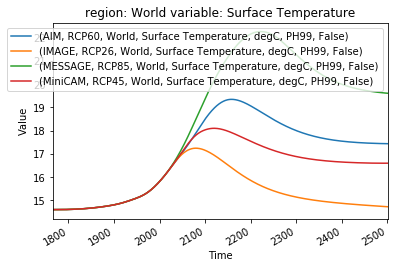

In [12]:
res.filter(
    variable="Surface Temperature",
    region="World",
).line_plot(x="time");